Find the final values of the hot and cold calibrations

#### Imports

In [12]:
import struct
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

#### Convert the dat files to txt / csv and plot the results

File saved as hot_obs2_converted.csv


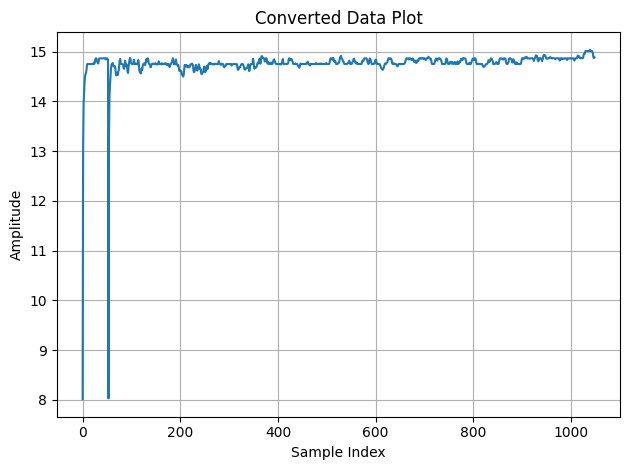

In [50]:
def convert_dat_file(input_file_path, output_format='txt'):
    """ Convert a .dat file into a .txt, .csv, .fits, .hdf, or .hdf5 file."""

    # Read the binary file contents
    with open(input_file_path, "rb") as f:
        data = f.read()

    # Convert binary data into list of 32-bit floats (little endian)
    floats = list(struct.iter_unpack('<f', data))
    flat_floats = [val[0] for val in floats]

    # Create DataFrame
    df = pd.DataFrame(flat_floats, columns=['Value'])

    # Determine output file path
    base_name = os.path.splitext(input_file_path)[0]
    output_format = output_format.lower()

    if output_format == 'csv':
        output_file = f"{base_name}_converted.csv"
        df.to_csv(output_file, index=False)

    elif output_format == 'txt':
        output_file = f"{base_name}_converted.txt"
        df.to_csv(output_file, index=False, sep='\t')

    elif output_format == 'fits':
        output_file = f"{base_name}_converted.fits"
        hdu = fits.PrimaryHDU(df['Value'].values)
        hdu.writeto(output_file, overwrite=True)

    elif output_format in ['hdf', 'hdf5']:
        output_file = f"{base_name}_converted.{output_format}"
        df.to_hdf(output_file, key='data', mode='w')

    else:
        raise ValueError("Unsupported output format. Choose 'csv', 'txt', 'fits', 'hdf', or 'hdf5'.")

    print(f"File saved as {output_file}")
    return output_file

# Usage
converted_path = convert_dat_file("hot_obs2.dat", output_format='csv')


# Plot the results
def plot_converted_file(file_path):
    file_path = file_path.lower()
    
    # Load data based on extension
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)

    elif file_path.endswith('.txt'):
        df = pd.read_csv(file_path, sep='\t')

    plt.plot(df['Value'])
    plt.title('Converted Data Plot')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_converted_file(converted_path)

#### Hot calibration computations

Threshold (> 85.0% of max value): 12.7790
Hot calibration value: 14.7742


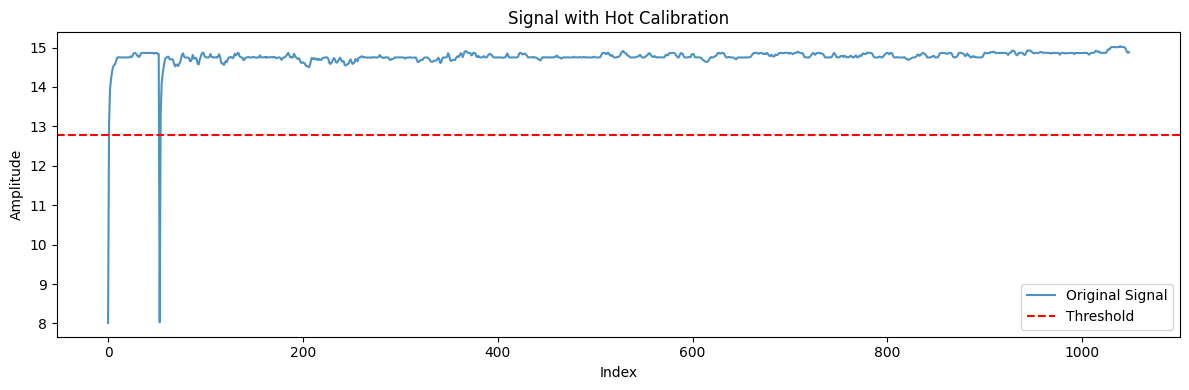

np.float64(14.774178788222464)

In [55]:
def compute_hot_calibration(file_path, top_value_fraction):
    # Load and clean data
    data = pd.read_csv(file_path, header=None).squeeze()
    data = pd.to_numeric(data, errors='coerce')
    data = data.dropna().values.astype(float)

    # Calculate threshold based on fraction of the max value
    max_value = np.max(data)
    threshold = max_value * top_value_fraction

    # Select all values above threshold
    filtered_values = data[data > threshold]

    # Compute mean of those values
    hot_calibration = np.mean(filtered_values) if filtered_values.size > 0 else np.nan

    print(f"Threshold (> {top_value_fraction*100:.1f}% of max value): {threshold:.4f}")
    print(f"Hot calibration value: {hot_calibration:.4f}")

    # Plot original signal and threshold line
    plt.figure(figsize=(12, 4))
    plt.plot(data, label="Original Signal", alpha=0.8)
    plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
    plt.title("Signal with Hot Calibration")
    plt.xlabel("Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return hot_calibration

# Example usage
compute_hot_calibration("hot_obs2_converted.csv", top_value_fraction=0.85)